In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv("creditcard.csv")
print('dataset shape:', card_df.shape)
card_df.head(3)

dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [72]:
from sklearn.model_selection import train_test_split
def get_preproccessed_df(df=None):
    df_copy=df.copy()
    df_copy.drop('Time',axis=1,inplace=True)
    return df_copy

In [73]:
def get_train_test_dataset(df=None):
    df_copy= get_preproccessed_df(df)
    X_features=df_copy.iloc[:,:-1]
    y_target=df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X_features,y_target,
                                                        test_size=0.2,random_state=0,stratify=y_target)
    return X_train, X_test,y_train,y_test

In [74]:
X_train, X_test, y_train, y_test =get_train_test_dataset(card_df)

In [75]:
print(y_train.value_counts()/y_train.shape[0]*100)

print(y_test.value_counts()/y_test.shape[0]*100)

0    99.827075
1     0.172925
Name: Class, dtype: float64
0    99.827955
1     0.172045
Name: Class, dtype: float64


In [76]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion= confusion_matrix(y_test,pred)
    accuracy=accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test,pred_proba)
    print('오차행렬')
    print(confusion)
    print('정확도 : {0: .4f}, 정밀도 : {1:.4f}, 재현율 :{2: .4f}, \
    f1 : {3:.4f},  auc : {4:.4f}'.format(accuracy,precision,recall,f1,roc_auc))
    

In [13]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test,lr_pred,lr_pred_proba)

오차행렬
[[56855     9]
 [   45    53]]
정확도 :  0.9991, 정밀도 : 0.8548, 재현율 : 0.5408,     f1 : 0.6625,  auc : 0.9475


In [14]:
def get_model_train_eval(model,ftr_train=None,ftr_test=None,tgt_train=None,tgt_test=None):
    model.fit(ftr_train,tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test,pred,pred_proba)

In [15]:
from lightgbm import LGBMClassifier

lgbm_clf= LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
# boost_from_average는 True 일 경우 극도로 불균형 분포를 이루는 경우 재현율 및 ROC 및 auc 성능이 매우 저하된다.
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)

오차행렬
[[56860     4]
 [   24    74]]
정확도 :  0.9995, 정밀도 : 0.9487, 재현율 : 0.7551,     f1 : 0.8409,  auc : 0.9782


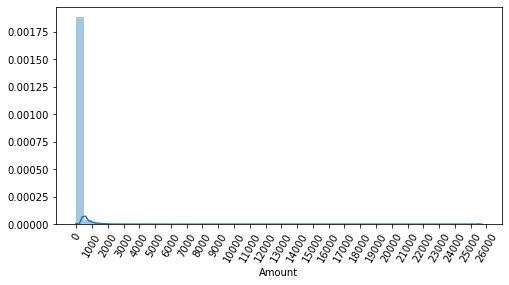

In [17]:
# 속성별 관련도 
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000),rotation=60)
sns.distplot(card_df['Amount'])

In [22]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0,'Amount_Scaler',amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    return df_copy

In [43]:
card_df_1=get_preprocessed_df(card_df)
X_train, X_test, y_train, y_test =train_test_split(card_df_1.iloc[:,:-1],card_df_1.iloc[:,-1],test_size=0.2,random_state=0)
print('로지스틱')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)
print('lgmb 스케일러')
lgbm_clf= LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)


로지스틱
오차행렬
[[56852     9]
 [   37    64]]
정확도 :  0.9992, 정밀도 : 0.8767, 재현율 : 0.6337,     f1 : 0.7356,  auc : 0.9779
lgmb 스케일러
오차행렬
[[56854     7]
 [   15    86]]
정확도 :  0.9996, 정밀도 : 0.9247, 재현율 : 0.8515,     f1 : 0.8866,  auc : 0.9778


In [49]:
#### 로그변환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled',amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    return df_copy

In [48]:
import numpy as np
### log와 log1p의 차이점
print(np.log(1e-1000+1))
print(np.log1p(1e-1000))

0.0
0.0


In [50]:
card_df_1=get_preprocessed_df(card_df)
X_train, X_test, y_train, y_test =train_test_split(card_df_1.iloc[:,:-1],card_df_1.iloc[:,-1],test_size=0.2,random_state=0)
print('로지스틱')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)
print('lgmb 스케일러')
lgbm_clf= LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)


로지스틱
오차행렬
[[56853     8]
 [   37    64]]
정확도 :  0.9992, 정밀도 : 0.8889, 재현율 : 0.6337,     f1 : 0.7399,  auc : 0.9789
lgmb 스케일러
오차행렬
[[56855     6]
 [   16    85]]
정확도 :  0.9996, 정밀도 : 0.9341, 재현율 : 0.8416,     f1 : 0.8854,  auc : 0.9772


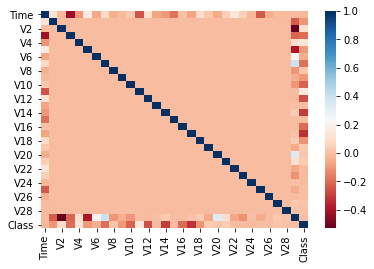

In [54]:
import seaborn as sns

plt.plot(figsize =(0,0))
corr = card_df.corr()
sns.heatmap(corr,cmap='RdBu')# v14 v12 v10



In [62]:
import numpy as np
def get_outlier(df=None, column=None,weight=1.5):
    fraud=df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values,75)
    iqr = quantile_75-quantile_25
    iqr_weight = iqr*weight
    lowest_val= quantile_25-iqr_weight
    highset_val = quantile_75+iqr_weight
    outlier_index = fraud[(fraud<lowest_val)|(fraud>highset_val)].index
    return outlier_index

In [81]:
card_df[card_df['Class']==1]['V14']

541      -4.289254
623      -1.692029
4920     -1.470102
6108     -6.771097
6329     -6.079337
            ...   
279863   -6.665177
280143   -5.210141
280149   -4.057162
281144   -6.416628
281674   -1.948883
Name: V14, Length: 492, dtype: float64

In [57]:
np.percentile(card_df['V14'].values,100)

10.5267660517847

In [ ]:
np.percentile(card_df['V14'].values,100)
np.max(card_df['V14'].values)

In [60]:
quantile_25 = np.percentile(card_df['V14'].values, 25)
quantile_75 = np.percentile(card_df['V14'].values,75)
print(quantile_25,quantile_75)

-0.4255740124549935 0.493149849218149


In [63]:
outlier_in = get_outlier(df=card_df,column='V14',weight=1.5)
print('이상치 데이터 인덱스 : ',outlier_in ) # 삭제 필요 

이상치 데이터 인덱스 :  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [84]:
#### 로그변환
def get_preproccessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled',amount_n)
    df_copy.drop(['Time','Amount'],axis=1,inplace=True)
    outlier_index = get_outlier(df=df_copy,column='V14',weight=1.5)
    df_copy.drop(outlier_index,axis=0,inplace=True)
    return df_copy

In [ ]:
def get_train_test_dataset(df=None):
    df_copy= get_preproccessed_df(df)
    X_features=df_copy.iloc[:,:-1]
    y_target=df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X_features,y_target,
                                                        test_size=0.2,random_state=0,stratify=y_target)
    return X_train, X_test,y_train,y_test

In [85]:
X_train, X_test,y_train, y_test= get_train_test_dataset(card_df)
print('로지스틱 스케일러')

get_model_train_eval(lr_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)
print('lgmb 스케일러')
get_model_train_eval(lgbm_clf,ftr_train=X_train,ftr_test=X_test,tgt_train=y_train,tgt_test=y_test)


로지스틱 스케일러
오차행렬
[[56853    10]
 [   34    64]]
정확도 :  0.9992, 정밀도 : 0.8649, 재현율 : 0.6531,     f1 : 0.7442,  auc : 0.9643
lgmb 스케일러
오차행렬
[[56859     4]
 [   19    79]]
정확도 :  0.9996, 정밀도 : 0.9518, 재현율 : 0.8061,     f1 : 0.8729,  auc : 0.9743


In [ ]:
### smote 오버 샘플링 적용 휴 모델 학습 평가 

In [86]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over= smote.fit_sample(X_train,y_train)
print('smote 적용 전',X_train.shape, y_train.shape)
print('smote 적용 후',X_train_over.shape, y_train_over.shape)
print('smonte 적용 후 레이블 값 분포 ', pd.Series(y_train_over).value_counts())

smote 적용 전 (227842, 29) (227842,)
smote 적용 후 (454904, 29) (454904,)
smonte 적용 후 레이블 값 분포  1    227452
0    227452
Name: Class, dtype: int64


In [87]:
# 증식된 것
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf,ftr_train=X_train_over,ftr_test=X_test,tgt_train=y_train_over,tgt_test=y_test)


오차행렬
[[55324  1539]
 [   10    88]]
정확도 :  0.9728, 정밀도 : 0.0541, 재현율 : 0.8980,     f1 : 0.1020,  auc : 0.9645


In [88]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

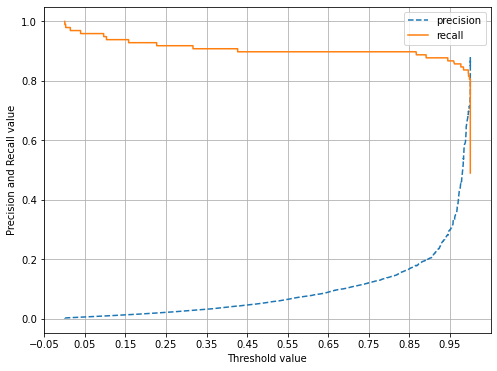

In [89]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

In [90]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차행렬
[[56856     7]
 [   17    81]]
정확도 :  0.9996, 정밀도 : 0.9205, 재현율 : 0.8265,     f1 : 0.8710,  auc : 0.9833
